## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Импорт библиотек.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.tree import DecisionTreeRegressor

from catboost import Pool, CatBoostRegressor, cv
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

Чтение и знакомство с данными.

In [2]:
df = pd.read_csv("autos.csv")

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В VehicleType, Gearbox, Model, FuelType, Repaired имеются пропуски. Удалять эти строки не целесообразно, так как мы потеряем много данных. Лучшим решением будет заполнить пропуски самым частовстречающимся значением (модой) этих столбцов, так как данные признаки являются катигориальными.  

In [5]:
df["VehicleType"] = df["VehicleType"].fillna(df["VehicleType"].mode().values[0])
df["Gearbox"] = df["Gearbox"].fillna(df["Gearbox"].mode().values[0])
df["Model"] = df["Model"].fillna(df["Model"].mode().values[0])
df["FuelType"] = df["FuelType"].fillna(df["FuelType"].mode().values[0])
df["Repaired"] = df["Repaired"].fillna("no")

In [6]:
df["FuelType"].isna().sum()

0

Проверим данные на дубликаты и избавимся от них.

In [7]:
df.duplicated().sum()

5

In [8]:
df = df.drop_duplicates()

"DateCrawled","DateCreated","LastSeen","NumberOfPictures","PostalCode" считаю целесообразным удалить, так как информации для предсказаний модели они не несут, но будут увеличивать время обучения.

In [9]:
df = df.drop(["DateCrawled","DateCreated","LastSeen","NumberOfPictures","PostalCode"],axis = 1)

Проверим данные на выбросы и мин/макс границы.

In [10]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,354364.000000,354364.000000,354364.000000,354364.000000,354364.000000
mean,4416.655608,2004.234471,110.093723,128211.373051,5.714641
std,4514.159690,90.228593,189.851590,37905.136957,3.726433
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


Присутствуют аномальные значения в RegistrationYear. Попробуем заменить все значения меньше 1930 и выше 2022 на последние.  
В RegistrationMonth есть нулевые значения. Заменим их 1.  
В Power ограничим максимальное значение 3000. Так же в данном столбце необходимо избавиться от выбросов. 
В Price также присутствуют выбросы. 

In [11]:
def RegistrationYear(value):
    if value > 2022:
        return 2022
    elif value < 1930:
        return 1930
    else:
        return value
df["RegistrationYear"] = df["RegistrationYear"].apply(RegistrationYear)

df.loc[df['RegistrationMonth'] == 0, 'RegistrationMonth'] = 1

df.loc[df['Power'] > 3000, 'Power'] = 3000

Удалим все строки, которые зафиксируем как выбросы.

In [12]:
def drop_lines(df,column):
    a = np.array(df[column].quantile(0.25))    
    b = np.array(df[column].quantile(0.75))
    c = a - 2 * (b - a)
    d = b + 2 * (b - a)
    index = []
    for index_value, value in zip(df[column].index, df[column]):
        if d <= value or value <= c:
            index.append(index_value)
    return index

In [13]:
df = df.drop(drop_lines(df,"Power"),axis = 0)

count    350361.000000
mean       4346.635276
std        4448.162979
min           0.000000
25%        1000.000000
50%        2699.000000
75%        6200.000000
max       20000.000000
Name: Price, dtype: float64

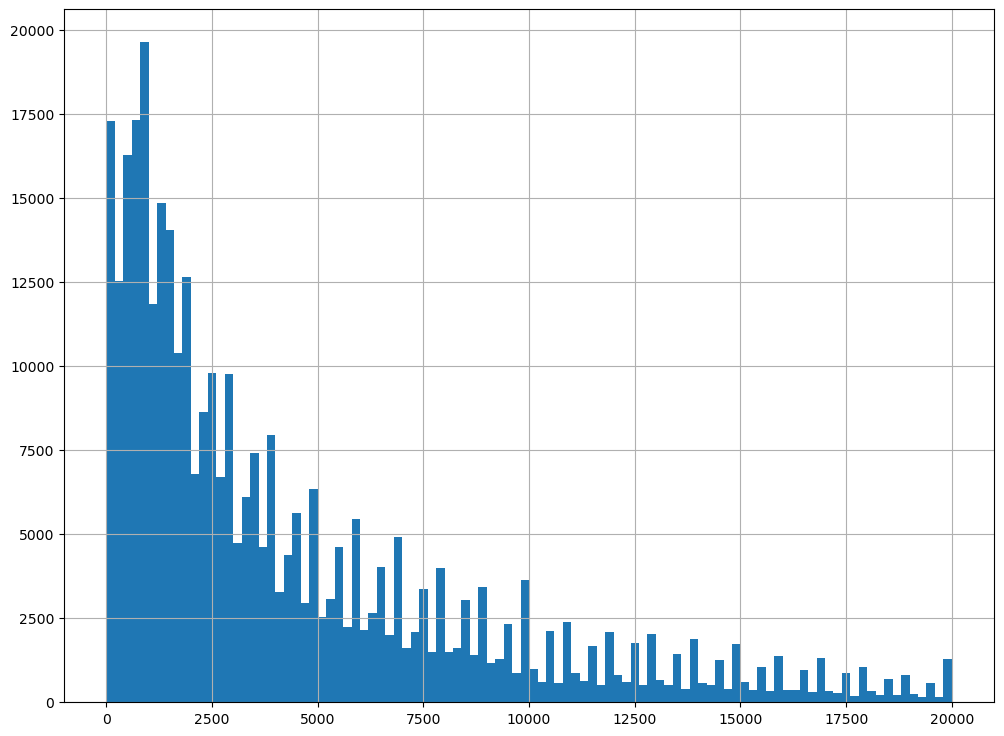

In [14]:
df['Price'].hist(bins=100, figsize=(12,9))
df['Price'].describe()

In [15]:
df['Price'].quantile([.05, 0.8])

0.05     200.0
0.80    7499.0
Name: Price, dtype: float64

In [16]:
df = df.query('350 <= Price')

Проверим корреляцию.

In [17]:
df.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
Price,1.000000,0.380777,0.458477,-0.380242,0.069337
RegistrationYear,0.380777,1.000000,0.101398,-0.201503,0.027802
Power,0.458477,0.101398,1.000000,0.080384,0.090204
Kilometer,-0.380242,-0.201503,0.080384,1.000000,-0.003322
RegistrationMonth,0.069337,0.027802,0.090204,-0.003322,1.000000


**Вывод**  
Провелась преобработка данных:
- пропуски в данных быои заполнены модой;  
- удалены дубликаты;    
- удалены лишние столбцы;  
- обработаны границы значений;  
- устранены выбросы;  
- проверена корреляция (самым коррелирующим значением с ценой является мощность).  

## Работа с выборками

Разделим целевой признак от остальных, подготовим признаки прямым кодированием и разделим данные на выборки.

In [21]:
original_features = df.drop('Price', axis=1)
target = df['Price']

features = pd.get_dummies(original_features, drop_first=True)

In [22]:
original_features_train_1, original_features_other, target_train, target_other = train_test_split(
    original_features, target, test_size=0.8, random_state=1234)

In [23]:
features_train = features.loc[original_features_train_1.index, :]
features_other = features.loc[original_features_other.index, :]

In [24]:
original_features_train, original_features_valid, original_target_train, target_train_valid = train_test_split(
    original_features_train_1, target_train,  test_size=0.75, random_state=1234)

In [25]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_other, target_other, test_size=0.5, random_state=1234)

## Обучение моделей

Модель дерева решений. В качестве гиперпараметра будем искать максимальную глубину. Так же зафиксируем средний RMSE.

In [26]:
%%time

model = DecisionTreeRegressor() 
max_depth = [x for x in range(2, 30)]
params = [{'criterion':['mse'], 
                'max_depth':max_depth, 
                'random_state':[1234]}]

clf = HalvingGridSearchCV(estimator=model, param_grid = params, cv = 2, n_jobs=-1 , scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Best parameters:")
print(clf.best_params_)

RMSE_DTR = ((clf.cv_results_['mean_test_score']).mean()*-1) ** 0.5
print("RMSE:", RMSE_DTR)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:

/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:

/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:

Best parameters:
{'criterion': 'mse', 'max_depth': 9, 'random_state': 1234}
RMSE: 2879.7182843238916
CPU times: user 734 ms, sys: 386 ms, total: 1.12 s
Wall time: 4.57 s


Модель градиентного бустинга. В качестве гиперпараметра будем искать скорость обучения.

In [27]:
%%time

model = CatBoostRegressor()
params = [{'learning_rate':[0.1, 0.2, 0.5, 0.8],
                'random_state':[12345],
                'verbose':[False]}]
clf = HalvingGridSearchCV(estimator=model, param_grid = params, cv = 2, n_jobs=-1 , scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Best parameters:")
print(clf.best_params_)

RMSE_CBR = ((clf.cv_results_['mean_test_score']).mean()*-1) ** 0.5
print("RMSE:", RMSE_CBR)

Best parameters:
{'learning_rate': 0.2, 'random_state': 12345, 'verbose': False}
RMSE: 1808.9016860566844
CPU times: user 9.35 s, sys: 3.05 s, total: 12.4 s
Wall time: 11.1 s


Модель LightGBM. В качестве гиперпараметра будем искать скорость обучения.

In [28]:
%%time

model = lgb.LGBMRegressor() 
params = [{'learning_rate':[0.1, 0.2, 0.5, 0.8],
                'random_state':[1234]}]

clf = HalvingGridSearchCV(estimator=model, param_grid =params, cv = 2, n_jobs=-1 , scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)

print("Best parameters:")
print(clf.best_params_)

RMSE_LGBM = ((clf.cv_results_['mean_test_score']).mean()*-1) ** 0.5
print("RMSE:", RMSE_LGBM)

Best parameters:
{'learning_rate': 0.2, 'random_state': 1234}
RMSE: 1826.914384004218
CPU times: user 1.4 s, sys: 171 ms, total: 1.57 s
Wall time: 3.17 s


**Вывод**  
По результатам обучающей выборки лучшей моделью является CatBoostRegressor с результатом RMSE в 1508.309. 

## Анализ моделей

Модель решающего дерева.

In [29]:
%%time

model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=11, 
                              random_state=1234) 
model.fit(features_train, target_train)

CPU times: user 1.46 s, sys: 239 ms, total: 1.7 s
Wall time: 517 ms


DecisionTreeRegressor(criterion='mse', max_depth=11, random_state=1234)

In [30]:
%%time

target_predict = model.predict(features_valid)

CPU times: user 98.2 ms, sys: 163 ms, total: 262 ms
Wall time: 334 ms


In [31]:
final_RMSE_DTR = mean_squared_error(target_valid, target_predict) ** 0.5   
final_RMSE_DTR

2075.4338039955132

Модель градиентного бустинга на оригинальной выборке.

In [32]:
%%time

model = CatBoostRegressor(learning_rate=0.2, 
                          random_state=1234, 
                          verbose=False, 
                          cat_features=["VehicleType","Gearbox","Model","FuelType","Brand","Repaired"]) 
model.fit(original_features_train, original_target_train)

CPU times: user 13.4 s, sys: 3.55 s, total: 17 s
Wall time: 3.64 s


In [33]:
%%time

target_predict_original = model.predict(original_features_valid)

CPU times: user 323 ms, sys: 24.3 ms, total: 347 ms
Wall time: 72.3 ms


In [34]:
final_RMSE_CBR_original = mean_squared_error(target_train_valid, target_predict_original) ** 0.5  
final_RMSE_CBR_original

1770.2886330425026

Модель градиентного бустинга на закодированной выборке.

In [35]:
%%time

model = CatBoostRegressor(learning_rate=0.2, 
                          random_state=1234, 
                          verbose=False) 
model.fit(features_train, target_train)

CPU times: user 9.37 s, sys: 3.07 s, total: 12.4 s
Wall time: 2.82 s


In [36]:
%%time

target_predict = model.predict(features_valid)

CPU times: user 331 ms, sys: 27.1 ms, total: 358 ms
Wall time: 80.1 ms


In [37]:
final_RMSE_CBR = mean_squared_error(target_valid, target_predict) ** 0.5  
final_RMSE_CBR

1661.2770640741828

Так как результаты не сильно отличаются, то в итоговый отчет будем включать только модель градиентного бустинга на закодированной выборке.

Модель LightGBM на закодированной выборке.

In [38]:
%%time

model = lgb.LGBMRegressor(learning_rate=0.2, 
                      random_state=1234)
model.fit(features_train, target_train)

CPU times: user 1.61 s, sys: 193 ms, total: 1.81 s
Wall time: 375 ms


LGBMRegressor(learning_rate=0.2, random_state=1234)

In [39]:
%%time

target_predict = model.predict(features_valid)

CPU times: user 2.49 s, sys: 411 ms, total: 2.9 s
Wall time: 471 ms


In [40]:
final_RMSE_LGBM = mean_squared_error(target_valid, target_predict) ** 0.5  
final_RMSE_LGBM

1716.5917021562502

Соберем данные в таблицу.

In [41]:
index = ['DecisionTreeRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']
data = {'RMSE на обучающей выборке':[RMSE_DTR, RMSE_CBR, RMSE_LGBM],
        'Время обучения на обучающей выборке, сек':[9.12, 21.9, 8.42],
        'RMSE на валидационной выборке':[final_RMSE_DTR, final_RMSE_CBR, final_RMSE_LGBM],
        'Время обучения на валидационной выборке, сек':[1.94, 2.93, 0.367],
        'Время предсказания модели, мсек':[96.9, 76.4, 523]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Рейтинг RMSE'] = (scores_data['RMSE на обучающей выборке'].min() /
                              scores_data['RMSE на обучающей выборке'])
scores_data['Рейтинг времени обучения'] = (scores_data['Время обучения на валидационной выборке, сек'].min() / 
                              scores_data['Время обучения на валидационной выборке, сек'])
scores_data['Рейтинг времени предсказания'] = (scores_data['Время предсказания модели, мсек'].min() / 
                              scores_data['Время предсказания модели, мсек'])
scores_data['Итоговый рейтинг'] = (scores_data['Рейтинг RMSE'] +
                                   scores_data['Рейтинг времени обучения'] + 
                                   scores_data['Рейтинг времени предсказания'])
scores_data

,RMSE на обучающей выборке,"Время обучения на обучающей выборке, сек",RMSE на валидационной выборке,"Время обучения на валидационной выборке, сек","Время предсказания модели, мсек",Рейтинг RMSE,Рейтинг времени обучения,Рейтинг времени предсказания,Итоговый рейтинг
DecisionTreeRegressor,2879.718284,9.12,2075.433804,1.940,96.9,0.628152,0.189175,0.788442,1.605769
CatBoostRegressor,1808.901686,21.90,1661.277064,2.930,76.4,1.000000,0.125256,1.000000,2.125256
LGBMRegressor,1826.914384,8.42,1716.591702,0.367,523.0,0.990140,1.000000,0.146080,2.136221


**Вывод**  
Лучшей моделью по времени обучения является LGBMRegressor.  
Лучшей моделью по времени предсказания является CatBoostRegressor.  
Лучшей моделью по качеству предсказаний является CatBoostRegressor. 

Лидер по совокупности параметров:
- Модель: CatBoostRegressor;  
- Гиперпараметры: learning_rate=0.2,random_state=1234, verbose=False;   
- RMSE на валидационной выборке: 1661.277064;  
- Время обучения на валидационной выборке, сек: 2.930;  
- Время предсказания модели, мсек: 76.4.

## Тестирование лучшей модели

In [42]:
%%time

model = CatBoostRegressor(learning_rate=0.2, 
                          random_state=1234, 
                          verbose=False) 
model.fit(features_train, target_train)

CPU times: user 9.45 s, sys: 3.07 s, total: 12.5 s
Wall time: 2.86 s


In [43]:
%%time

target_predict = model.predict(features_test)

CPU times: user 359 ms, sys: 47.4 ms, total: 406 ms
Wall time: 69.1 ms


In [44]:
final_RMSE_CBR = mean_squared_error(target_test, target_predict) ** 0.5  
final_RMSE_CBR

1642.3484721466536

## Вывод

Итак, нашей итоговой моделью стал CatBoostRegressor с такими результатами:
- Гиперпараметры: learning_rate=0.2,random_state=1234, verbose=False;   
- RMSE на тестовой выборке: 1642.3484721466536;  
- Время обучения, сек: 2.94;  
- Время предсказания модели, мсек: 131.  